# Logistic Regression in TensorFlow

Using the airlines tweets dataset, this exercise aims to demonstrate how deep learning model can be used to distinguish between 'negative' and 'positive' tweets (sentiment analysis), i.e. classic Logistic Regression using TensorFlow instead of SciKit-Learn.

Text data needs to be vectorized before training the model, and using TF-IDF vectorizer should be the best approach in this case, since we want to isolate the 'important' words to classify between labels.

**NOTE: TensorFlow does not accept sparse matrix as input data so training and test sets must be converted to NumPy arrays.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
# Set random seed in NumPy and TensorFlow to reproduce results

np.random.seed(0)
tf.random.set_seed(0)

In [4]:
df = pd.read_csv('data/AirlineTweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# We only care about the text and sentiment labels

df = df[['airline_sentiment', 'text']]

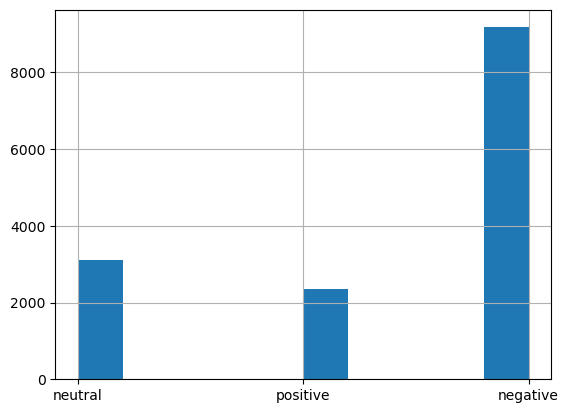

In [7]:
df['airline_sentiment'].hist();

**Very imbalanced dataset, with negative comments highly over-represented compared to both neutral and positive comments.**

In [8]:
# Make copy before adding new column to prevent warning message, and remove neutral tweets

df = df[df['airline_sentiment'] != 'neutral'].copy()

In [9]:
# Map labels to 0 (negative) and 1 (positive)

target_map = {'positive': 1, 'negative': 0}

df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [11]:
# 11,541 tweets

df.shape

(11541, 3)

In [12]:
df_train, df_test = train_test_split(df, random_state=42)

## TF-IDF vectorize training and test sets

In [13]:
# TF-IDF vectorize text data (set limit of 2000 features)

vectorizer = TfidfVectorizer(max_features=2000)

# Training and test features

X_train = vectorizer.fit_transform(df_train['text'])

X_test = vectorizer.transform(df_test['text'])

In [14]:
# Training and test target labels

y_train = df_train['target']

y_test = df_test['target']

In [15]:
# Features must not be sparse matrix before passing into TensorFlow

X_train = X_train.toarray()

X_test = X_test.toarray()

In [16]:
# 8,655 tweets and 2,000 words

X_train.shape

(8655, 2000)

In [17]:
# Save input dimensions (no of columns)

D = X_train.shape[1]

In [18]:
D

2000

## Build the model

In [19]:
# Inner layer (2000 features)
i = Input(shape=(D,))

# Hidden layer - sigmoid activation is included in compile()
x = Dense(1)(i)

# Model framework
model = Model(i, x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


**2000 'weights' for 2000 words, and one parameter for the bias term - one bias for a single neuron output (0 or 1)**

In [22]:
model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [23]:
# Reduce epochs & enlarge batch size, and include the test set to validate against

r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=128)

Epoch 1/40
68/68 [==============================] - 1s 5ms/step - loss: 0.5046 - accuracy: 0.7920 - val_loss: 0.3976 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 0s 2ms/step - loss: 0.3759 - accuracy: 0.7963 - val_loss: 0.3393 - val_accuracy: 0.8205
Epoch 3/40
68/68 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8186 - val_loss: 0.3027 - val_accuracy: 0.8420
Epoch 4/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2850 - accuracy: 0.8446 - val_loss: 0.2768 - val_accuracy: 0.8604
Epoch 5/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2576 - accuracy: 0.8639 - val_loss: 0.2582 - val_accuracy: 0.8777
Epoch 6/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2367 - accuracy: 0.8809 - val_loss: 0.2444 - val_accuracy: 0.8881
Epoch 7/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2202 - accuracy: 0.8931 - val_loss: 0.2336 - val_accuracy: 0.9006
Epoch 8/40
68/68 [==

In [24]:
r.history

{'loss': [0.5045670866966248,
  0.37594738602638245,
  0.32225117087364197,
  0.2850383520126343,
  0.25758275389671326,
  0.23672157526016235,
  0.22024497389793396,
  0.20679542422294617,
  0.19561468064785004,
  0.18607792258262634,
  0.177777960896492,
  0.170583114027977,
  0.16419273614883423,
  0.15849445760250092,
  0.15340042114257812,
  0.14859788119792938,
  0.14438286423683167,
  0.14046570658683777,
  0.1368151158094406,
  0.13350394368171692,
  0.13033466041088104,
  0.12748587131500244,
  0.124634750187397,
  0.12208089232444763,
  0.11965155601501465,
  0.11741885542869568,
  0.11521412432193756,
  0.11306016147136688,
  0.11110685765743256,
  0.10929569602012634,
  0.10745558887720108,
  0.10581135004758835,
  0.10412269085645676,
  0.10252176970243454,
  0.10103905946016312,
  0.09961594641208649,
  0.09819996356964111,
  0.09686010330915451,
  0.09557873010635376,
  0.09433446824550629],
 'accuracy': [0.7920277118682861,
  0.7963027358055115,
  0.8186019659042358,
  

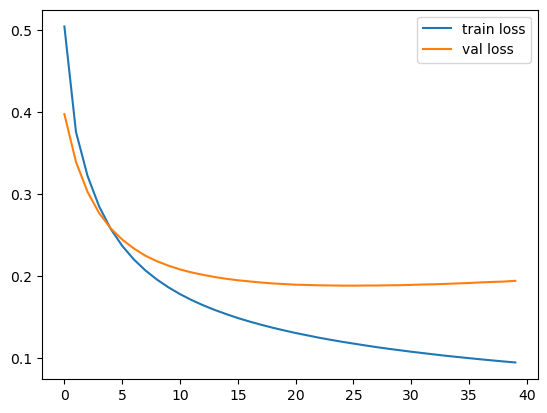

In [25]:
# Plot training and test losses per epoch

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

**There is a nice decrease in losses but as expected, test loss does not go as low as training loss.**

**The training loss keeps decreasing, but the test loss increases slightly at the end. This suggests some 'overfitting', and you could use a callback to save the best model during training (according to validation loss).**

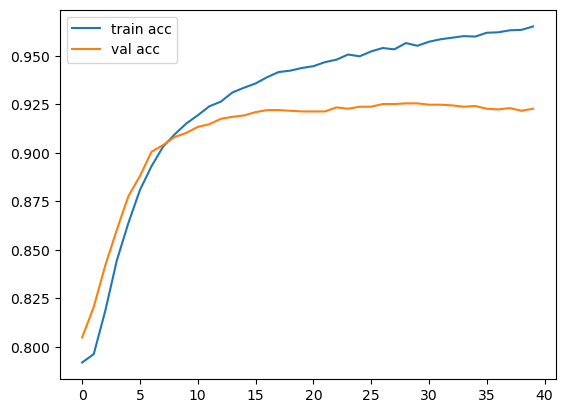

In [26]:
# Plot training and test accuracy per epoch

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

**There is a nice steady increase in accuracy, with test accuracy scoring lower than training accuracy, as expected.**

**Note again how the test accuracy decreases slightly at the end, confirming the presence of 'overfitting'. Remember that the dataset is imbalanced.**

## Make predictions and run through metrics

Run the test set through the predictive function, in order to test the validation data against other classification metrics, especially those that account for an imbalanced dataset.

Note that TensorFlow generates logits, not probabilities, and we need both to use SciKit-Learn metric functions.

In [27]:
# True or False values (greater than 0), convert to numbers and flatten to one-dimensional array

preds = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 777us/step


In [28]:
preds

array([0., 1., 0., ..., 0., 0., 0.])

In [30]:
# Approx 79% harmonic blend, which is not bad...

print("Test F1 score:", f1_score(y_test, preds))

Test F1 score: 0.7924528301886793


In [31]:
cm = confusion_matrix(y_test, preds, normalize='true')

cm

array([[0.96685321, 0.03314679],
       [0.25399645, 0.74600355]])

In [32]:
# Function to plot confusion matrix heatmap

def plot_cm(cm):
    classes = ['negative', 'positive'] 
    df_cm = pd.DataFrame(cm, index=classes, columns=classes) 
    ax = sn.heatmap(df_cm, annot=True, fmt='g') 
    ax.set_xlabel("Predicted") 
    ax.set_ylabel("Target")

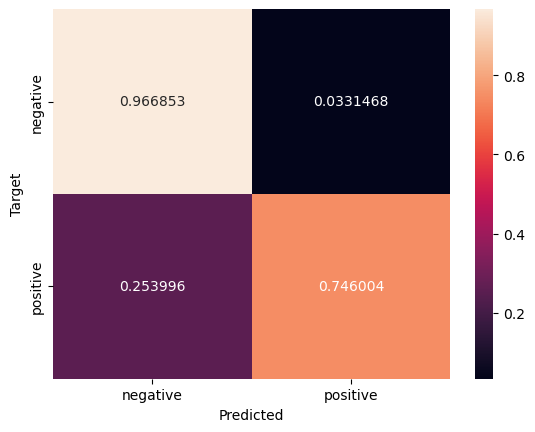

In [33]:
# Confusion Matrix - a lot less false positives than false negatives (depends what matters)
# The best predictions are for the negative class, which makes sense as it is over-represented

plot_cm(cm)

In [34]:
# In order to compute AUC score, you need the logits values

logits = model.predict(X_test)

logits

91/91 [==============================] - 0s 762us/step


array([[-5.2162743],
       [ 7.081123 ],
       [-6.0641284],
       ...,
       [-1.7602507],
       [-4.352695 ],
       [-3.192782 ]], dtype=float32)

In [35]:
# AUC score of approx 95% is good

print("Test AUC score:", roc_auc_score(y_test, logits))

Test AUC score: 0.9547394232820456


## Check learned parameters

In [36]:
model.layers

In [37]:
# Get parameters of dense layer (2 arrays - weights for each feature and the bias term)

model.layers[1].get_weights()

[array([[-3.7594306],
        [ 3.2930984],
        [-1.5727311],
        ...,
        [ 2.0647573],
        [ 1.6236324],
        [-2.914441 ]], dtype=float32),
 array([-0.25063276], dtype=float32)]

In [38]:
# We only want the weights

w = model.layers[1].get_weights()[0]

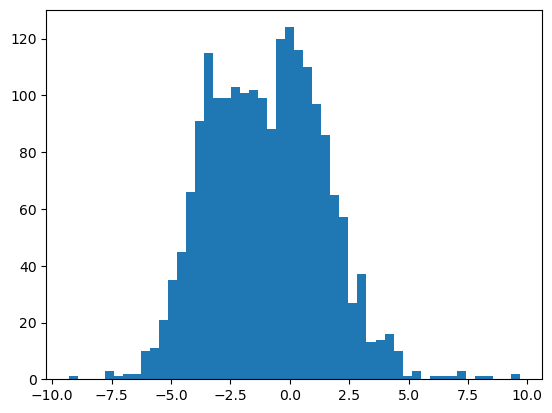

In [41]:
# Plot distribution of weight values

plt.hist(w, bins=50);

In [39]:
# Access word-to-index mapping

word_index_map = vectorizer.vocabulary_

word_index_map['expensive']

653

In [42]:
# Look at the weights for most positive words - try with different threshold values

threshold = 2

print("Most positive words:\n")

word_weight_tuples = []

for word, index in word_index_map.items():
    weight = w[index, 0] 
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])

for i in range(10):
    word, weight = word_weight_tuples[i] 
    print(word, weight)

Most positive words:

thank 9.680252
thanks 9.383908
worries 8.346183
great 7.914956
awesome 7.3620844
love 7.266407
excellent 7.134867
kudos 6.657526
amazing 6.476131
best 6.1335196


In [43]:
# Look at the weights for most negative words

print("Most negative words:\n")

word_weight_tuples = []

for word, index in word_index_map.items():
    weight = w[index, 0] 
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])

for i in range(10):
    word, weight = word_weight_tuples[i] 
    print(word, weight)

Most negative words:

worst -9.297472
paid -7.772392
rude -7.6396394
not -7.6199193
disappointed -7.2339687
nothing -6.807879
website -6.7556148
hung -6.6280556
instead -6.627508
list -6.229083


**EXERCISE: Apply the deep learning classification model to spam detection in emails.**